# 09. PyTorch Model Deployment

Machine learning model deployment is making your ML models available to someone or something else.

## 0. Get Setup

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 39.71 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. FoodVision Mini Model Deployment Experiment Outline

### 3 questions
1. What is my most ideal ML model scenario? --> accuracy >= 95%, 30FPS+ or 30ms latency
2. Where is my model going to go? -->
3. How is my model going to function?

We will build two model experiments:
1. EffNetV2 feature extractor (from notebook 07)
2. ViT feature extractor (from notebook 08)

## 3. Creating the EffNetB2 Model

In [5]:
import torchvision

effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device) # also weights=DEFAULT works

for param in effnetb2.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 132MB/s]


In [6]:
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=3,
              bias=True)).to(device)

### 3.1 Functionizing EffNet Creation

In [7]:
def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42):

  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=num_classes)).to(device)

  return model, transforms

In [8]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3)

In [9]:
from torchinfo import summary

summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.2 Creating DataLoaders for EffNetB2

In [10]:
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

In [11]:
class_names, len(train_dataloader_effnetb2), len(test_dataloader_effnetb2)

(['pizza', 'steak', 'sushi'], 15, 5)

### 3.3 Training EffNetB2

In [12]:
from going_modular.going_modular import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=0.001)

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


### 3.4 Plotting Loss Curves

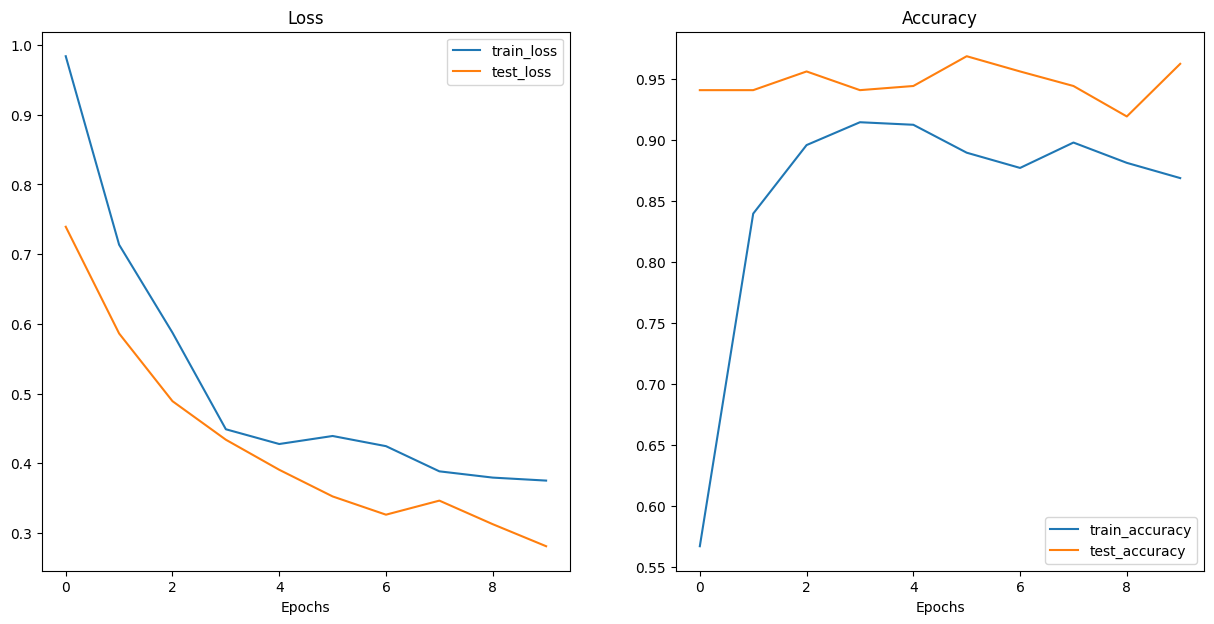

In [13]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2

In [14]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_effnetb2_pretrained.pth")

[INFO] Saving model to: models/09_effnetb2_pretrained.pth


### 3.6 Inspect the Size of EffNetB2

In [15]:
from pathlib import Path

effnetb2_path = Path("models/09_effnetb2_pretrained.pth")
effnetb2_size_bytes = effnetb2_path.stat().st_size / (1024 * 1024)
print(f"[INFO] EffNetB2 model size: {effnetb2_size_bytes:.2f} MB")

[INFO] EffNetB2 model size: 29.83 MB


### 3.7 Collecting EffNetB2 Stats

In [16]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [17]:
# Statistics dict
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "model_size (MB)": effnetb2_size_bytes,
                  "model_params": effnetb2_total_params}
effnetb2_stats

{'test_loss': 0.2810868382453918,
 'test_acc': 0.9625,
 'model_size (MB)': 29.8327579498291,
 'model_params': 7705221}

## 4. Creating the ViT Model

Let's do the same steps for our ViT model!

In [18]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [19]:
def create_vit_model(num_classes: int = 3,
                          seed: int = 42):

  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.heads = nn.Sequential(
    nn.Linear(in_features=768,
              out_features=num_classes)).to(device)

  return model, transforms

In [20]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 178MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [21]:
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

In [22]:
from torchinfo import summary

summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [23]:
from going_modular.going_modular import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.001)

set_seeds()
vit_results = engine.train(model=vit,
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


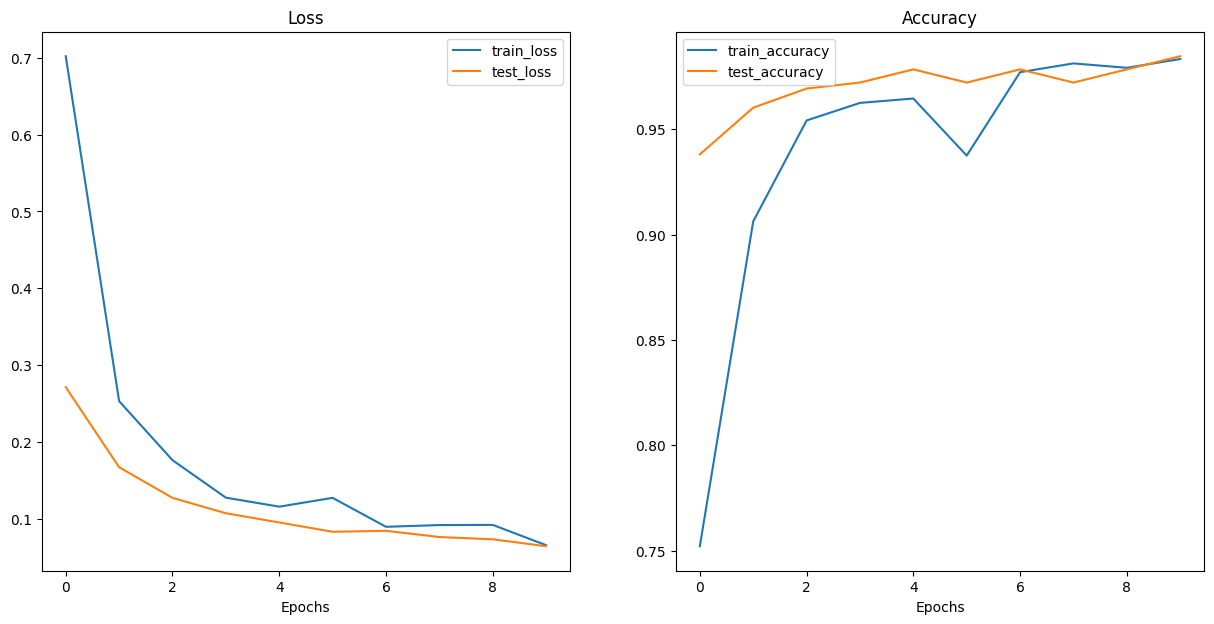

In [24]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [25]:
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_vit_pretrained.pth")

[INFO] Saving model to: models/09_vit_pretrained.pth


In [26]:
from pathlib import Path

vit_path = Path("models/09_vit_pretrained.pth")
vit_size_bytes = vit_path.stat().st_size / (1024 * 1024)
print(f"[INFO] ViT model size: {vit_size_bytes:.2f} MB")

[INFO] ViT model size: 327.36 MB


In [27]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [28]:
# Statistics dict
vit_stats = {"test_loss": vit_results["test_loss"][-1],
              "test_acc": vit_results["test_acc"][-1],
              "model_size (MB)": vit_size_bytes,
              "model_params": vit_total_params}
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'model_size (MB)': 327.363733291626,
 'model_params': 85800963}

# 5. Making Predictions with our Models and Timing them

In [29]:
from pathlib import Path

# All test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

### 5.1 Creating a Function to Make Across the Test Dataset

In [30]:
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  pred_list = []

  # loop through target input paths
  for path in tqdm(paths):
    pred_dict = {} # a dictionary for each sample
    pred_dict["image_path"] = path
    class_name = path.parent.stem # folder name = class name
    pred_dict["class_name"] = class_name

    start_time = timer()

    # getting image and transforming it
    img = Image.open(path)
    transformed_img = transform(img).unsqueeze(dim=0).to(device) # also adding a batch dimension

    # preparing model for inference
    model = model.to(device)
    model.eval()

    # pass image through model
    with torch.inference_mode():
      pred_logit = model(transformed_img)
      pred_prob = torch.softmax(pred_logit, dim=1) # logits to probs
      pred_label = torch.argmax(pred_prob, dim=1) # probs to label
      pred_class = class_names[pred_label.cpu()] # label to class name (Python variables live in CPU so hardcoding that)

      # add values to the sample dict
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time - start_time, 4)

    pred_dict["correct"] = class_name == pred_class # check if the prediction is correct
    pred_list.append(pred_dict)

  return pred_list

### 5.2 Making and Timing Predictions with EffNetB2

Let's test our function!

2 things to note:
1. Device - we hardcode the predictions to happen on CPU, as GPU may not be available when the model is deployed
2. Transforms - make sure we use same transforms that the model training uses

In [31]:
effnetb2_test_preds = pred_and_store(paths=test_data_paths,
                                     model=effnetb2,
                                     transform=effnetb2_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [32]:
effnetb2_test_preds[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/44810.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7921,
  'pred_class': 'pizza',
  'time_for_pred': 0.3186,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2782998.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.71,
  'pred_class': 'pizza',
  'time_for_pred': 0.1128,
  'correct': True}]

In [33]:
# Turn the dicts into a DataFrame
import pandas as pd

effnetb2_test_preds_df = pd.DataFrame(effnetb2_test_preds)
effnetb2_test_preds_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.7921,pizza,0.3186,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.7100,pizza,0.1128,True
2,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.7846,pizza,0.1126,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9211,pizza,0.1060,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9468,pizza,0.1040,True


In [34]:
# Check number of correct preds
effnetb2_test_preds_df.correct.value_counts()

,count
correct,
True,144
False,6


In [35]:
# avg time per pred (note: on colab, these are not that fast...)
effnetb2_avg_time_per_pred = round(effnetb2_test_preds_df.time_for_pred.mean(), 4)
print(f"EffNetB2 avg pred time: {effnetb2_avg_time_per_pred}s")

EffNetB2 avg pred time: 0.0996s


In [36]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_avg_time_per_pred

### 5.3 Making and Timing Predictions with ViT

In [37]:
vit_test_preds = pred_and_store(paths=test_data_paths,
                                model=vit,
                                transform=vit_transforms,
                                class_names=class_names,
                                device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [38]:
# Turn the dicts into a DataFrame
import pandas as pd

vit_test_preds_df = pd.DataFrame(vit_test_preds)
vit_test_preds_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.9917,pizza,0.7081,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9990,pizza,0.5306,True
2,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.9989,pizza,0.5226,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9987,pizza,0.4904,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9983,pizza,0.3542,True


In [39]:
# Check number of correct preds
vit_test_preds_df.correct.value_counts()

,count
correct,
True,148
False,2


In [40]:
# avg time per pred (note: on colab, these are not that fast...)
vit_avg_time_per_pred = round(vit_test_preds_df.time_for_pred.mean(), 4)
print(f"ViT avg pred time: {vit_avg_time_per_pred}s")

ViT avg pred time: 0.3875s


In [41]:
vit_stats["time_per_pred_cpu"] = vit_avg_time_per_pred

## 6. Comparing Model Results

In [42]:
# Stat dicts into DFs
df = pd.DataFrame([effnetb2_stats, vit_stats])
df["model"] = ["EffNetB2", "ViT"]
df["test_acc"] = round(df.test_acc * 100, 2)
df

,test_loss,test_acc,model_size (MB),model_params,time_per_pred_cpu,model
0,0.281087,96.25,29.832758,7705221,0.0996,EffNetB2
1,0.064435,98.47,327.363733,85800963,0.3875,ViT


Which model is better?
* loss - ViT
* accuracy - ViT
* number of parameters - EffNetB2 (usually more parameters = takes longer to compute, sometimes models with higher parameters are still fast)
* model size - EffNetB2 (for deploying to a mobile device, we want a small model)
* prediction time (CPU) - EffNetB2 (neither of these achieve the 30+FPS goal at least on Google Colab

In [43]:
# Comparing more...
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,model_size (MB),model_params,time_per_pred_cpu
ViT to EffNetB2 ratios,0.229233,1.023065,10.973298,11.135432,3.890562


### 6.1 Visualizing the Speed vs. Performance Tradeoff

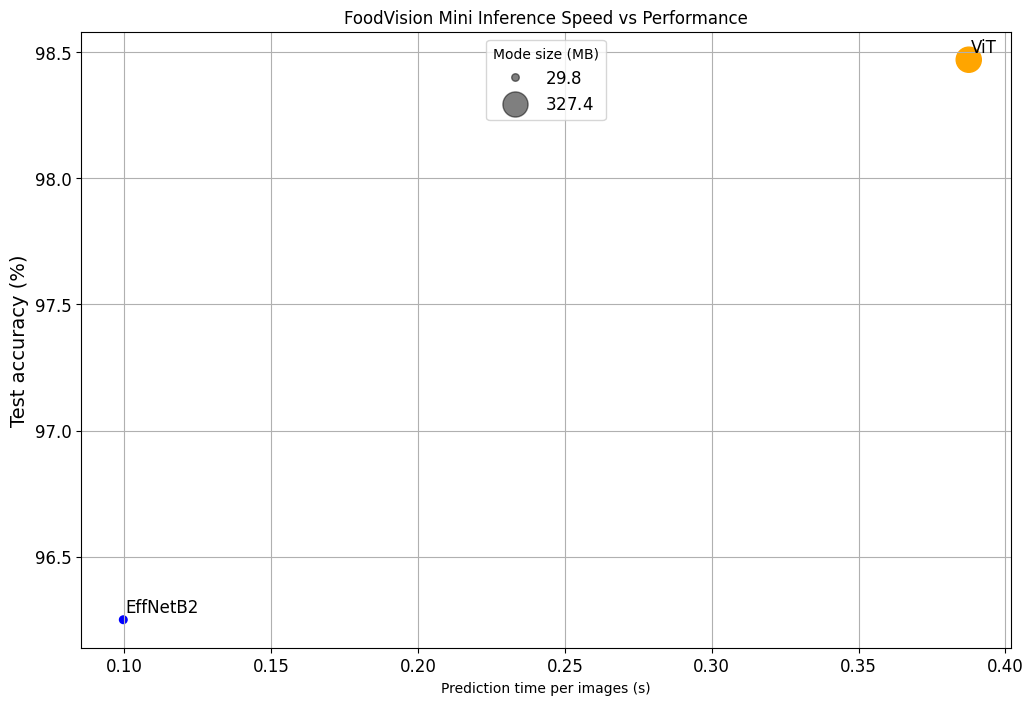

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

ax.set_title("FoodVision Mini Inference Speed vs Performance")
ax.set_xlabel("Prediction time per images (s)")
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="upper center",
                              title="Mode size (MB)",
                              fontsize=12)

plt.savefig("09-foodvision-model-comparison.png")

## 7. Creating a Gradio Demo for FoodVision Mini

We chose to deploy EffNetB2 model for the FoodVision Mini app.

What is Gradio? The fastest way to demo ML models with a simple web interface!

In [45]:
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 5.41.0


### 7.1 Gradio Overview

Gradio helps building ML demos.

Why create one? So others can try our models and we can test them in real world.

The overall premise of Gradio is to map
```inputs -> functions/model -> outputs```

### 7.2 Creating a Function to Map our Inputs and Outputs

In [46]:
effnetb2 = effnetb2.to("cpu")
next(iter(effnetb2.parameters())).device # checking...

device(type='cpu')

Let's create function to go from inputs to outputs (food_class_label, prediction_time)!

In [47]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  start_time = timer()

  img = effnetb2_transforms(img).unsqueeze(0) # add batch dimension
  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=1) # get prediction probs

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  return pred_labels_and_probs, pred_time

In [48]:
# Let's test!

import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

random_image_path = random.sample(test_data_paths, k=1)[0]

image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}")

pred_dict, pred_time = predict(img=image)
pred_dict, pred_time

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg


({'pizza': 0.9941244721412659,
  'steak': 0.0028508638497442007,
  'sushi': 0.003024693811312318},
 0.0894)

### 7.3 Creating a List of Example Images

The examples for Gradio can be created with the `examples` parameter, let's create it...

In [49]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/2752603.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/593071.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/1482489.jpg']]

### 7.4 Building a Gradio Interface

Now, we're ready to use `gr.Interface`!

In [50]:
import gradio as gr

title = "FoodVision Mini"
description = "An EfficientNetB2 feature extractor model classifying between 3 classes of food: pizza, steak and sushi."
article = "Created at [09. PyTorch Model Deployment](https://github.com/veetirajaniemi/pytorch-learning/blob/main/09_pytorch_model_deployment.ipynb)."

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4239858d2e81b19430.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 8. Turning Demo into a Deployable App

Let's prepare our app files to host them on Hugging Face spaces.

### 8.1 What is Hugging Face Spaces?

It offers a simple way to host ML demo apps on your own profile!

### 8.2 Deployed App Structure

We want to put all the app files into a single directory. This structure is the simplest to use in our case.

```python
demos/
└── foodvision_mini/
    ├── 09_effnetb2_pretrained.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

### 8.3 Creating a `demos` Folder

In [51]:
import shutil
from pathlib import Path

foodvision_mini_demo_path = Path("demos/foodvision_mini")

if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)

foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

### 8.4 Creating a Folder of Example Images

We need 3 example images from the test set.

In [52]:
import shutil
from pathlib import Path

foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 3 chosen example pics
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# Copy examples to the directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


We need the example file paths into a list of lists to use in our Gradio app.

In [53]:
import os

example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/592799.jpg'], ['examples/2582289.jpg'], ['examples/3622237.jpg']]

### 8.5 Moving our Model to Demo Directory

In [54]:
import shutil

effnet_model_path = "models/09_effnetb2_pretrained.pth"
effnet_model_destination = foodvision_mini_demo_path / effnet_model_path.split("/")[1]

try:
  print(f"[INFO] Trying to move {effnet_model_path} to {effnet_model_destination}")
  shutil.move(src=effnet_model_path,
              dst=effnet_model_destination)
  print(f"[INFO] {effnet_model_path} moved to {effnet_model_destination}")
except:
  print(f"[INFO] No model found at {effnet_model_path}, perhaps already been moved?")
  print(f"[INFO] Model exists at {effnet_model_destination}: {effnet_model_destination.exists()}")


[INFO] Trying to move models/09_effnetb2_pretrained.pth to demos/foodvision_mini/09_effnetb2_pretrained.pth
[INFO] models/09_effnetb2_pretrained.pth moved to demos/foodvision_mini/09_effnetb2_pretrained.pth


### 8.6 Turning our EffNetB2 into a Python Script `model.py`

In [55]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42):

  device = "cuda" if torch.cuda.is_available() else "cpu"

  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=num_classes)).to(device)

  return model, transforms

Writing demos/foodvision_mini/model.py


### 8.7 Turning Gradio App into a Python script `app.py`

We will have 4 major parts:
1. Imports and class names setup
2. Model and transforms preparation
3. Predict function
4. Gradio app (interface + launch command)

In [56]:
%%writefile demos/foodvision_mini/app.py

import gradio as gr
import os
import torch
from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

class_names = ["pizza", "steak", "sushi"]

effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3
)

effnetb2.load_state_dict(
    torch.load(
        f="09_effnetb2_pretrained.pth",
        map_location=torch.device("cpu") # load model to the CPU
    )
)

def predict(img) -> Tuple[Dict, float]:
  start_time = timer()

  img = effnetb2_transforms(img).unsqueeze(0) # add batch dimension
  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=1) # get prediction probs

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  return pred_labels_and_probs, pred_time

title = "FoodVision Mini"
description = "An EfficientNetB2 feature extractor model classifying between 3 classes of food: pizza, steak and sushi."
article = "Created at [09. PyTorch Model Deployment](https://github.com/veetirajaniemi/pytorch-learning/blob/main/09_pytorch_model_deployment.ipynb)."

example_list = [["examples/" + example] for example in os.listdir("examples")]

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

if __name__ == "__main__":
  demo.launch(share=True)

Writing demos/foodvision_mini/app.py


### 8.8 Creating `requirements.txt`

What software dependencies we need for the app?

* torch
* torchvision
* gradio

In [57]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4
numpy<2

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini App on Hugging Face Spaces

### 9.1 Downloading FoodVision Mini App Files
We want to download our app so we can upload it to Hugging Face

In [58]:
!ls demos/foodvision_mini

09_effnetb2_pretrained.pth  app.py  examples  model.py	requirements.txt


In [59]:
# Change into FoodVision directory and zip inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__" "*ipynb_checkpoints*"

  adding: 09_effnetb2_pretrained.pth (deflated 8%)
  adding: app.py (deflated 52%)
  adding: examples/ (stored 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 46%)
  adding: requirements.txt (deflated 4%)


In [60]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision_mini.zip")
except:
  print("Skipping download, not on Google Colab, please download the zip manually!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2 Uploading to Hugging Face

The application was uploaded to Hugging Face spaces: https://huggingface.co/spaces/vegeeee/foodvision-mini

## 10. Creating Bigger FoodVision

Let's update to the bigger FoodVision application with all Food101 classes!

### 10.1 Creating a Model and Transforms

In [61]:
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(
    num_classes=101,
    seed=42
)

In [62]:
summary(effnetb2_food101, (1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 101]                  --
├─Sequential: 1-1                                       [1, 1408, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         (864)
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         (64)
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         (1,448)
│    │    └─MBConv: 3-5                                 [1, 16, 112, 112]         (612)
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-6                        

In [63]:
effnetb2_transforms # we could add some data augmentation...

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [64]:
food_101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])
food_101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

### 10.2 Getting the Full Dataset

In [65]:
from torchvision import datasets
from pathlib import Path

data_dir = Path("data")

train_data = datasets.Food101(
    root=data_dir,
    split="train",
    transform=food_101_train_transforms,
    download=True
)

test_data = datasets.Food101(
    root=data_dir,
    split="test",
    transform=effnetb2_transforms, # no data augmentation on the test data!
    download=True
)

100%|██████████| 5.00G/5.00G [00:58<00:00, 84.8MB/s]


In [66]:
food101_class_names = train_data.classes
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Create a Subset of Food101 Data

Why? We want the application to be fast...

Let's use 20% of the full data.

In [67]:
from torch.utils.data import random_split

def split_dataset(dataset: torchvision.datasets,
                  split_size: float = 0.2,
                  seed: int = 42):

  # Create split lengths
  len_1 = int(len(dataset) * split_size) # defaults to 20%
  len_2 = len(dataset) - len_1 # remaining length
  print(f"[INFO] Splitting dataset of length {len(dataset)} into {len_1} and {len_2}")

  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                 lengths=[len_1, len_2],
                                                                 generator=torch.manual_seed(seed))

  return random_split_1, random_split_2

In [68]:
train_data_food101, _ = split_dataset(dataset=train_data,
                                      split_size=0.2)

test_data_food101, _ = split_dataset(dataset=test_data,
                                     split_size=0.2)

[INFO] Splitting dataset of length 75750 into 15150 and 60600
[INFO] Splitting dataset of length 25250 into 5050 and 20200


In [69]:
len(train_data_food101), len(test_data_food101)

(15150, 5050)

### 10.4 Turn Datasets into DataLoaders

In [70]:
import torch
import os

BATCH_SIZE = 32
NUM_WORKERS = 2 # a very experimental value

train_dataloader_food101 = torch.utils.data.DataLoader(
    dataset=train_data_food101,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
    )

test_dataloader_food101 = torch.utils.data.DataLoader(
    dataset=test_data_food101,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
    )

In [71]:
len(train_dataloader_food101), len(test_dataloader_food101) # check num of batches..

(474, 158)

### 10.5 Training the FoodVision Model

* 5 epochs
* optimizer: `torch.optim.Adam(lr=0.001)`
* loss function: `torch.nn.CrossEntropyLoss(label_smoothing=0.1)`

Label smoothing is a regularization technique preventing overfitting.

Without label smoothing and 5 classes:

```
[0.00, 0.00, 0.99, 0.01, 0.00]
```

With label smoothing and 5 classes:
```
[0.01, 0.01, 0.96, 0.01, 0.01]
```

**Note**: The training may take 15-20 minutes on Colab's GPU's.

In [72]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=0.001)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101,
                                        test_dataloader=test_dataloader_food101,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device="cuda")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6397 | train_acc: 0.2818 | test_loss: 2.8052 | test_acc: 0.4865
Epoch: 2 | train_loss: 2.8642 | train_acc: 0.4367 | test_loss: 2.4605 | test_acc: 0.5455
Epoch: 3 | train_loss: 2.6490 | train_acc: 0.4860 | test_loss: 2.3630 | test_acc: 0.5547
Epoch: 4 | train_loss: 2.5493 | train_acc: 0.5063 | test_loss: 2.3109 | test_acc: 0.5715
Epoch: 5 | train_loss: 2.5000 | train_acc: 0.5236 | test_loss: 2.2746 | test_acc: 0.5852


### 10.6 Inspecting Loss Curves

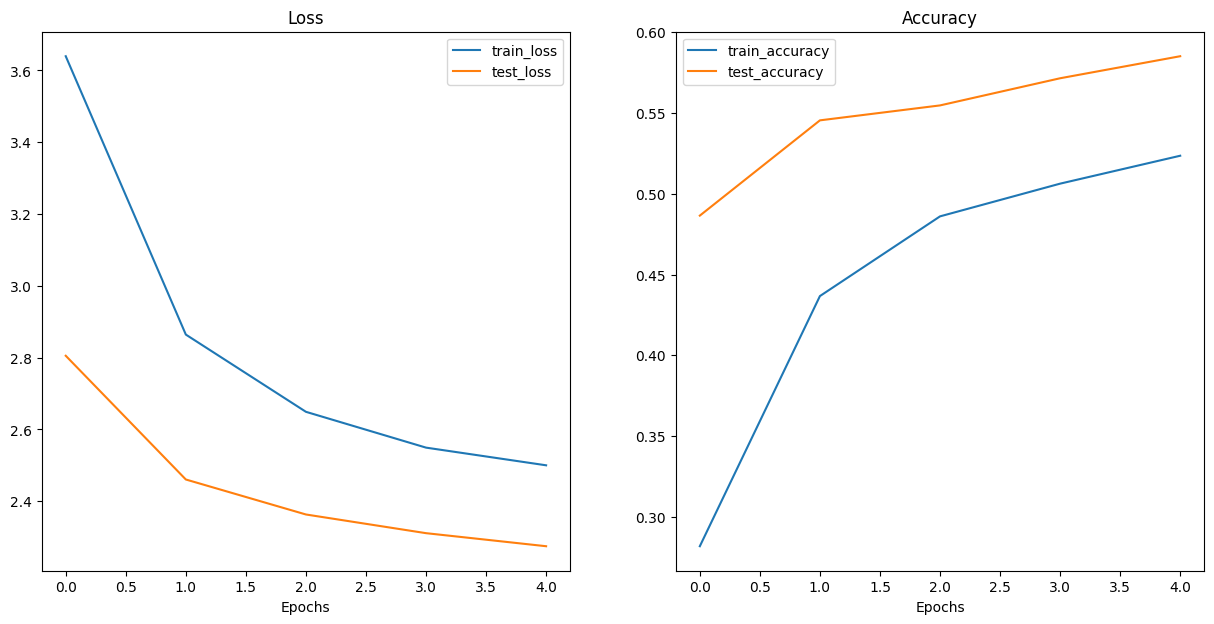

In [73]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

### 10.7 Save and Load Bigger Model

In [74]:
from going_modular.going_modular import utils

effnet_food101_path = "09_pretrained_effnetb2_food101.pth"

utils.save_model(model=effnetb2_food101,
                target_dir="models",
                model_name=effnet_food101_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_food101.pth


In [75]:
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

loaded_effnetb2_food101.load_state_dict(
    torch.load(f=f"models/{effnet_food101_path}")
)

<All keys matched successfully>

### 10.8 Checking Model Size

In [76]:
from pathlib import Path

effnetb2_food101_size = Path(f"models/{effnet_food101_path}").stat().st_size / (1024 * 1024)
print(f"[INFO] EffNetB2 Food101 model size: {effnetb2_food101_size:.2f} MB")

[INFO] EffNetB2 Food101 model size: 30.36 MB


## 11. Turning FoodVision into a Deployable App

Let's aim to build the following structure:
```python
demos/
└── foodvision/
    ├── effnetb2_food101.pth
    ├── app.py
    ├── class_names.txt
    ├── examples/
    │   ├── example_1.jpg
    ├── model.py
    └── requirements.txt
```

In [77]:
from pathlib import Path

foodvision_demo_path = Path("demos/foodvision")
foodvision_demo_path.mkdir(parents=True, exist_ok=True)
(foodvision_demo_path / "examples").mkdir(parents=True, exist_ok=True)

In [78]:
!ls demos/foodvision

examples


### 11.1 Moving Model to Demo Directory

In [80]:
!mv models/09_pretrained_effnetb2_food101.pth demos/foodvision/09_pretrained_effnetb2_food101.pth

### 11.2 Saving Food101 Class Names to a File

Let's save the classes into a .txt file so that we can use them in the app!

In [81]:
foodvision_class_names_path = foodvision_demo_path / "class_names.txt"

with open(foodvision_class_names_path, "w") as f:
  print(f"[INFO] Saving Food101 class names to {foodvision_class_names_path}")
  f.write("\n".join(food101_class_names))

[INFO] Saving Food101 class names to demos/foodvision/class_names.txt


In [84]:
# Let's try to do the reverse
with open(foodvision_class_names_path, "r") as f:
  print(f"[INFO] Reading Food101 class names from {foodvision_class_names_path}")
  food101_class_names_loaded = [food.strip() for food in f.readlines()]
food101_class_names_loaded[:7]

[INFO] Reading Food101 class names from demos/foodvision/class_names.txt


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets']

### 11.3 Turning FoodVision into a Python Script

In [85]:
%%writefile demos/foodvision/model.py

import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes: int = 101,
                          seed: int = 42):

  device = "cuda" if torch.cuda.is_available() else "cpu"

  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=num_classes)).to(device)

  return model, transforms

Writing demos/foodvision/model.py


### 11.4 Turning FoodVision Gradio App into Python Script

We will have 4 major parts:
1. Imports and class names setup (for class names, import from .txt file now)
2. Model and transforms preparation
3. Predict function
4. Gradio app (interface + launch command)

In [86]:
%%writefile demos/foodvision/app.py

import gradio as gr
import os
import torch
from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

with open("class_names.txt", "r") as f:
  class_names = [food_name.strip() for food_name in f.readlines()]

effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101
)

effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_food101.pth",
        map_location=torch.device("cpu") # load model to the CPU
    )
)

def predict(img) -> Tuple[Dict, float]:
  start_time = timer()

  img = effnetb2_transforms(img).unsqueeze(0) # add batch dimension
  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=1) # get prediction probs

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  return pred_labels_and_probs, pred_time

title = "FoodVision"
description = "An EfficientNetB2 feature extractor model classifying between 101 classes of food."
article = "Created at [09. PyTorch Model Deployment](https://github.com/veetirajaniemi/pytorch-learning/blob/main/09_pytorch_model_deployment.ipynb)."

example_list = [["examples/" + example] for example in os.listdir("examples")]

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=10, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

if __name__ == "__main__":
  demo.launch(share=True)

Writing demos/foodvision/app.py


### 11.5 Creating `requirements.txt`

What software dependencies we need for the app?

* torch
* torchvision
* gradio

In [87]:
%%writefile demos/foodvision/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4
numpy<2

Writing demos/foodvision/requirements.txt


### 11.6 Downloading FoodVision Files

In [88]:
# Change into FoodVision directory and zip inside
!cd demos/foodvision && zip -r ../foodvision.zip * -x "*.pyc" "*.ipynb" "*__pycache__" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_food101.pth (deflated 8%)
  adding: app.py (deflated 52%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/tiramisu.jpg (deflated 1%)
  adding: model.py (deflated 46%)
  adding: requirements.txt (deflated 4%)


In [89]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision.zip")
except:
  print("Skipping download, not on Google Colab, please download the zip manually!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 11.7 Uploading to Hugging Face

The application was uploaded to Hugging Face spaces: https://huggingface.co/spaces/vegeeee/foodvision